# How Weather Variability Influences Precipitation Levels in Lake Tahoe: A La Nina and El Nino Study

## By: Garrick Hague


## Objective:

### 1) Clean and slice both datasets so they can be used in this analysis. 

### 2) Create a dataset of anomalies by using sea surface temperature data and precipitation amounts.

### 3) Find the sea surface location with the highest correlation with respect to the Lake Tahoe Region.

### 4) Find what linear regression model is the best at predicting precipitation at Lake Tahoe.


## Background 

### The focus of this project is on the Southern Oscillation, a crucial region located in the equatorial Pacific Ocean, as illustrated in the figure below. Scientists have long relied on the sea surface temperatures at this location to make accurate predictions about how weather patterns might be affected across the United States. When the water temperature rises, it results in low pressure at the surface. Conversely, if the water temperature falls, it causes high pressure in the same region, subsequently driving distinct weather patterns across the globe. Against this backdrop, our project aims to explore the impact of Southern Oscillation teleconnections on the Lake Tahoe region, an area renowned for its unique weather patterns.

![image-2.png](NinoRegions.png)

In [1]:

import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import cartopy.feature as cfeature
import cartopy.crs as ccrs 
import cartopy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats


# Reading in the data:

In [2]:

# This is the sea surface temp data most used in the analysis
sst_data = xr.open_dataset('sst.mon.mean.nc')

# Precipitation data used in the analysis. 
precip_data =xr.open_dataset('precip.monitor.mon.total.1x1.v2020.nc', decode_times = True, drop_variables= 'time_bnds', mask_and_scale = True)

# This data is used to compare the anomalys made in this analysis
sst_anom_data = xr.open_dataset('sst.mon.anom.nc')


### Can find data in these links below. 

SST data: https://www.psl.noaa.gov/data/gridded/data.cobe.html

Precip data: https://www.psl.noaa.gov/data/gridded/data.gpcc.html

# Part 1: Processing Datasets



In [3]:

# Looking at the coordinates for the datasets. 
print('sst data', sst_data.coords, '\n')
print('precip data', precip_data.coords, '\n')


sst data Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2022-09-01 

precip data Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2022-07-01 



## Sea Surface Temperature Data

### - 1x1 degree resolution
### - latitude starts from the north pole then moves down to the south pole
### - longitude is in degrees east 
### - monthly mean from 1891-01-01 - 2022-09-01


## Precipitation Data

### - 1x1 Degree Resolution
### - latitude starts from the north pole then moves down to the south pole
### - longitude is in degrees east 
### - Monthly mean from 1982-01-01 - 2022-07-01



In [4]:

# Looking at the dimensions of datasets
print(sst_data.dims)
print(precip_data.dims)


Frozen({'lat': 180, 'lon': 360, 'time': 1581})
Frozen({'lat': 180, 'lon': 360, 'time': 487})


### 3-dimensional data with both datasets having the same lat and lon but sea surface temperature has much more elements. 


In [5]:
# Attributes of datasets
print('SST Attributes:', '\n', sst_data.attrs, '\n')
print('Precip Attributes:', '\n', precip_data.attrs, '\n')


SST Attributes: 
 {'title': 'COBE Sea Surface Temperature Analysis', 'history': 'created June 2011 at ESRL/PSD using the grib data from JRA.', 'platform': 'Analyses', 'original_source': 'http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_catalog?projectname=NEAR-GOOS', 'Conventions': 'CF-1.2', 'institution': 'NOAA ESRL/PSD', 'comment': 'recent values (w/i last year) may change as dataset is updated. It is a monitoring dataset.', 'dataset_title': 'COBE Sea Surface Temperature', 'References': 'https://www.psl.noaa.gov/data/gridded/data.cobe.html'} 

Precip Attributes: 
 {'title': 'GPCP 1x1 Precipitation Monitoring', 'Conventions': 'CF-1.0', 'history': 'CAS Jul 2021', 'platform': 'Observation', 'source': 'PSL', 'References': 'https://www.psl.noaa.gov/data/gridded/data.gpcc.html', 'Original_Source': 'http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm\n is the webpage and the data is at ftp://ftp.dwd.de/pub/data/gpcc/download.html', 'Reference': "Users of the data sets are kindly requ

### The COBE sea surface temperature analysis dataset that was created by the JMA climate data assimilation system and a 25-year Japanese reanalyses.

### The GPCP 1x1 precipitation monitor is based on quality-controlled data from 7,000 stations that was interpolated into a grid. 


# Part 2: Processing the datasets

### Precipitation Dataset

In [6]:

# max and minimum values of the datasets
print('max sst:', sst_data['sst'].max().values, ', min sst:', sst_data['sst'].min().values, '\n')
print('max precip data:', precip_data['precip'].max().values, ', min precip data:', precip_data['precip'].min().values, '\n')


max sst: 34.869998931884766 , min sst: -1.7999995946884155 

max precip data: 9.969209968386869e+36 , min precip data: 0.0 



### The range of sea surface temperatures (SST) observed in this study is quite broad, with the maximum value reaching an impressive 34.9 Celsius, while the minimum plunges to a bone-chilling -1.79 Celsius. Although it seems reasonable to assume that the minimum temperature would be located at the polar regions and the maximum at the equator, further analysis is needed to verify this hypothesis.

### Meanwhile, the maximum precipitation value recorded in the data is a staggering 3.27073817860461555e+34 feet, a figure that is far too high to be realistic. Consequently, these anomalous values will be replaced with "nan" values to ensure the accuracy and validity of the subsequent analyses.

In [7]:

# changing the precipitation max value to Nan value
precip_data = precip_data.where(precip_data['precip'] < 9.969209968386869e+36)

# verifying change in max value
print('max precip data:', precip_data['precip'].max().values, ', min precip data:', precip_data['precip'].min().values)


max precip data: 2418.929931640625 , min precip data: 0.0




### Slicing data over Lake Tahoe

In [8]:

# setting the latitude and longitude as a global variable 
lat_low = 38
lat_high =40

lon_low = 360-121
lon_high = 360-119

# code needed to only getting values over the Lake Tahoe region 
tahoe_precip = precip_data.sel(lat=slice(lat_high,lat_low), lon=slice(lon_low, lon_high))
print(tahoe_precip.coords)


Coordinates:
  * lat      (lat) float32 39.5 38.5
  * lon      (lon) float32 239.5 240.5
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2022-07-01


### The coordinates are over the desired region 

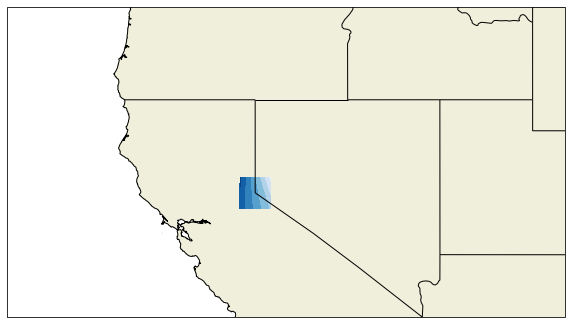

In [9]:

# plotting one-time frame to show the region of interest
cmap=plt.get_cmap('Blues')

fig,ax= plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(10,10))

p = plt.contourf(tahoe_precip.lon, 
                 tahoe_precip.lat, 
                 tahoe_precip.sel(time='1998-02-01')['precip'], 
                 cmap=cmap, 
                 transform=ccrs.PlateCarree())
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='black')
ax.set_extent([-128, -110, 35, 45])


### This will be the window that will be analyzed in this project

### Diving into the data

In [10]:

# use the nino 3.4 location to look at how this affects precip amounts. 
selected_sst = sst_anom_data.sel(lat=slice(-5,5), lon=slice(190, 240), time=slice('1982-01-01', '2022-07-01'))
selected_sst_mean = selected_sst.mean(dim=['lat', 'lon'])


In [11]:

# making a spatial average over the Lake Tahoe region
tahoe_mean_precip = tahoe_precip.mean(dim=['lat', 'lon'])
print(tahoe_mean_precip, '\n')


<xarray.Dataset>
Dimensions:  (time: 487)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2022-07-01
Data variables:
    precip   (time) float32 3.992 95.06 141.9 60.63 21.3 ... nan nan nan nan nan 



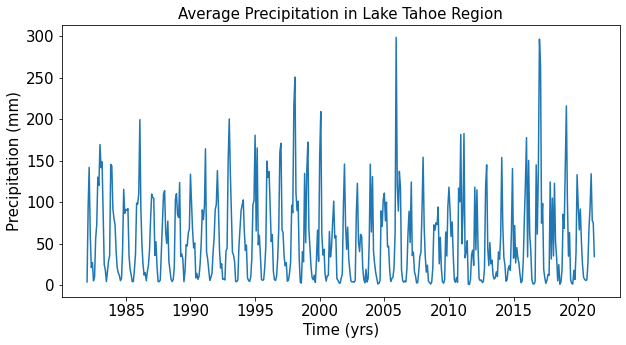

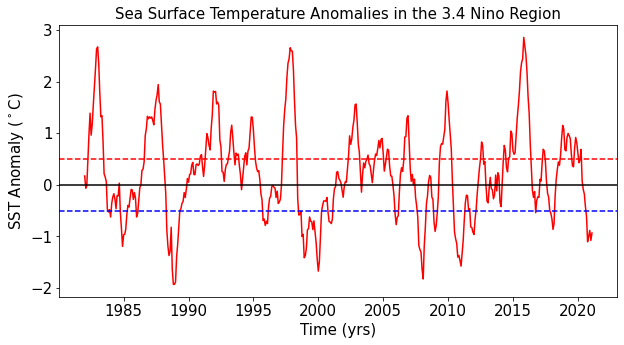

In [12]:

# graph for the average precipitation in the Lake Tahoe region

fig,ax= plt.subplots(figsize=(10,5))

plt.plot(tahoe_mean_precip.time, tahoe_mean_precip['precip'])

plt.title('Average Precipitation in Lake Tahoe Region', fontsize=15)
plt.xlabel('Time (yrs)', fontsize=15)
plt.ylabel('Precipitation (mm)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# graph for the sea surface temperature anomalys in the 3.4 nino region. 

fig,ax= plt.subplots(figsize=(10,5))

plt.plot(selected_sst_mean.time, selected_sst_mean['sst'], c='r')

# creating horizontal lines to show the El Nino / La Nina thresholds
ax.axhline(y=0.5, color='r', linestyle='--',label='El Nino threshold')
ax.axhline(y=-0.5, color='b', linestyle='--',label='La Nina threshold')
ax.axhline(y=0, color='k', linestyle='-')

plt.title('Sea Surface Temperature Anomalies in the 3.4 Nino Region', fontsize=15)
plt.xlabel('Time (yrs)', fontsize=15)
plt.ylabel('SST Anomaly ($^\circ$C)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()


### The graph with average precipitation amount shows the region's seasonality in which it's hard to decipher an increase or decrease due to El Nino or La Nina.
 

In [13]:

# looking at the months with highest precipitation
print(tahoe_mean_precip.sel(time=slice('1985-01-01', '1989-12-31')).idxmax())
print(tahoe_mean_precip.sel(time=slice('1990-01-01', '1994-12-31')).idxmax())
print(tahoe_mean_precip.sel(time=slice('1995-01-01', '1999-12-31')).idxmax())
print(tahoe_mean_precip.sel(time=slice('2000-01-01', '2004-12-31')).idxmax())
print(tahoe_mean_precip.sel(time=slice('2005-01-01', '2009-07-01')).idxmax())
print(tahoe_mean_precip.sel(time=slice('2010-01-01', '2014-12-31')).idxmax())
print(tahoe_mean_precip.sel(time=slice('2015-01-01', '2022-07-01')).idxmax())


<xarray.Dataset>
Dimensions:  ()
Data variables:
    precip   datetime64[ns] 1986-02-01
<xarray.Dataset>
Dimensions:  ()
Data variables:
    precip   datetime64[ns] 1993-01-01
<xarray.Dataset>
Dimensions:  ()
Data variables:
    precip   datetime64[ns] 1998-02-01
<xarray.Dataset>
Dimensions:  ()
Data variables:
    precip   datetime64[ns] 2000-02-01
<xarray.Dataset>
Dimensions:  ()
Data variables:
    precip   datetime64[ns] 2005-12-01
<xarray.Dataset>
Dimensions:  ()
Data variables:
    precip   datetime64[ns] 2011-03-01
<xarray.Dataset>
Dimensions:  ()
Data variables:
    precip   datetime64[ns] 2017-01-01


### The data presented above indicates that the peak precipitation values tend to occur during the winter months. However, this seasonality may obscure the underlying patterns that could help to inform the predictive model. To address this issue, we will employ a resampling method that allows us to examine the winter months in greater detail, with the hope of extracting the signal from the noise. By focusing on this narrower time frame, we aim to uncover the underlying dynamics of precipitation patterns and minimize any confounding effects that may arise due to seasonal variations.

In [14]:

# start and end times used to create the anomalies for both datasets
start_time = '1982-01-01'
end_time = '2012-12-31'


# resampling the data into seasons
resample_quarter_sst = sst_data.resample(time='Q-FEB').mean(dim="time")
resample_quarter_precip = tahoe_precip.resample(time='Q-FEB').mean(dim="time")


# group by each quarter
grouped_sst = resample_quarter_sst.groupby('time.season')
grouped_precip = resample_quarter_precip.groupby('time.season')

# lets get the mean precip from 1982-01-01 - 2012-12-31
time_mean_sst = grouped_sst['DJF'].sel(time=slice(start_time, end_time)).mean(dim='time')
time_mean_precip = grouped_precip['DJF'].sel(time=slice(start_time, end_time)).mean(dim='time')

# lets create the a dataset that has anomalous values
DJF_anomaly_sst = grouped_sst['DJF'] - time_mean_sst
DJF_anomaly_precip = grouped_precip['DJF'] - time_mean_precip

# taking a spatial average
DJF_time_precip = DJF_anomaly_precip.mean(dim=['lat','lon'])



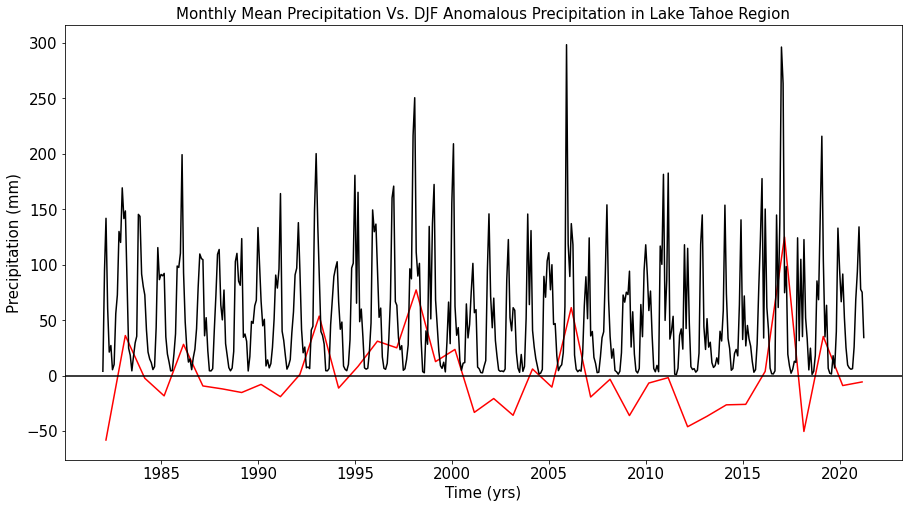

In [15]:

#creating a graph to compare precipitation amounts with dec,jan, and feb precipitation anomalies 
fig,ax= plt.subplots(figsize=(15,8))

plt.plot(DJF_time_precip.time, DJF_time_precip['precip'], c = 'r') # precip amount
plt.plot(tahoe_mean_precip.time, tahoe_mean_precip['precip'], c ='k') # precip anomalies

plt.title('Monthly Mean Precipitation Vs. DJF Anomalous Precipitation in Lake Tahoe Region', fontsize=15)

plt.xlabel('Time (yrs)', fontsize=15)
ax.axhline(y=0, color='k', linestyle='-')
plt.ylabel('Precipitation (mm)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


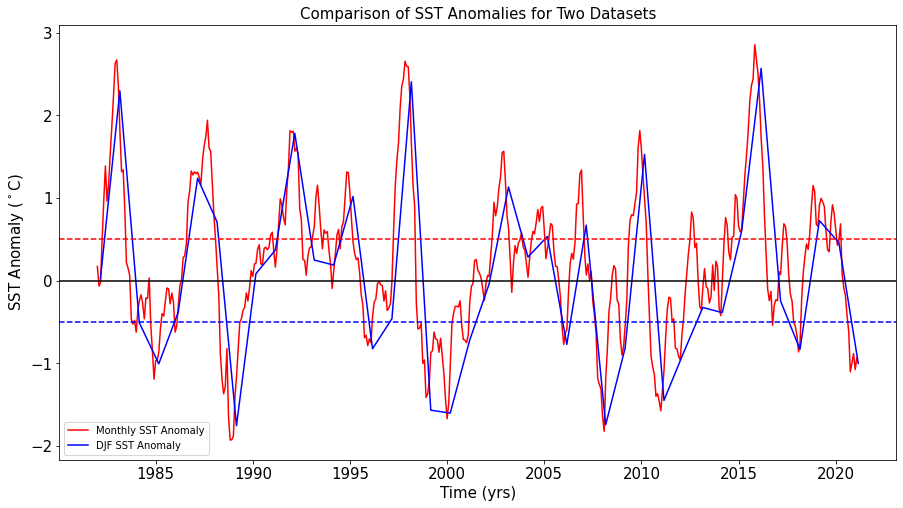

In [16]:

# Need to analysis same lat,lon and time to varify the created anomalys worked properly. 
DJF_selected_sst = DJF_anomaly_sst.sel(lat=slice(5,-5), lon=slice(190, 240), time=slice('1982-01-01', '2021-02-28'))

DJF_sst_nino = DJF_selected_sst.mean(dim=['lat', 'lon']) # taking a spatial average over dataset
numpy_sst_nino = DJF_sst_nino['sst'].to_numpy() # converting to numpy array

# creating the figure to compare results
fig,ax= plt.subplots(figsize=(15,8))

plt.plot(selected_sst_mean.time, selected_sst_mean['sst'], c='r') # the data that we know thats correct.
plt.plot(DJF_sst_nino.time, DJF_sst_nino['sst'], c='b') # the data needed to be checked. 

ax.axhline(y=0.5, color='r', linestyle='--',label='El Nino threshold')
ax.axhline(y=-0.5, color='b', linestyle='--',label='La Nina threshold')
ax.axhline(y=0, color='k', linestyle='-')
plt.title('Comparison of SST Anomalies for Two Datasets', fontsize=15)
plt.xlabel('Time (yrs)', fontsize=15)
plt.ylabel('SST Anomaly ($^\circ$C)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(['Monthly SST Anomaly','DJF SST Anomaly'])

plt.show()



### In the chart above, a strong El Nino is present in 1997-1998. When the max precip was looked at from 1995 through the end of 1999, the max precip value is in Feb of 1998. This is why this date was selected for the graph below.  


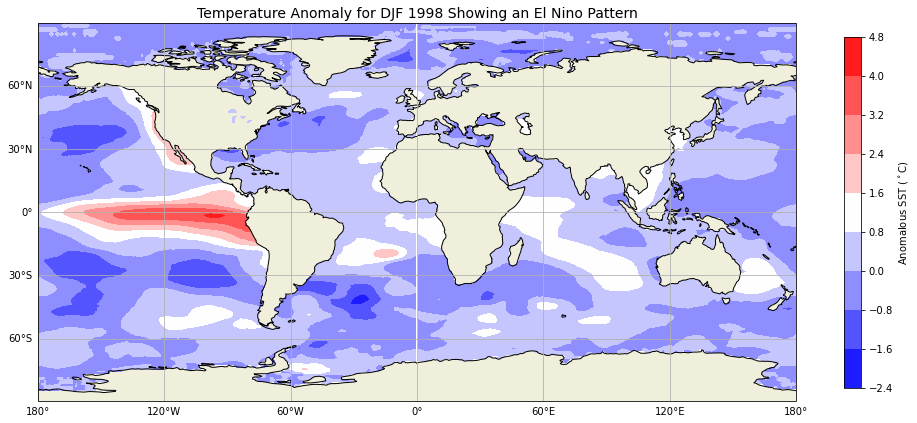

In [17]:

# lets verify an El Nino pattern is present for a known timeframe
cmap=plt.get_cmap('bwr')

fig,ax= plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(17,17))


p = plt.contourf(DJF_anomaly_sst['lon'], DJF_anomaly_sst['lat'], 
                 DJF_anomaly_sst.sel(time='1998-02-28T00:00:00.000000000')['sst'], 
                 cmap=cmap, 
                 transform=ccrs.PlateCarree())


ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True)
gl.right_labels= False
gl.top_labels=False

cb = fig.colorbar(p, ax=ax, shrink=0.38)
cb.set_label('Anomalous SST ($^\circ$C)', fontsize=10)

plt.title('Temperature Anomaly for DJF 1998 Showing an El Nino Pattern', fontsize=14)



plt.show()


### This map shows warmer water in the 3.4 region which is a strong indicator of El Nino. This is consistent with what we could expect which verifies that the sst data that was made into an anomaly is functioning properly. 



# Part 3: Correlation


### Let's now look at the correlation between the sea surface temperature data for the entire globe and compare that with precipitation in the Lake Tahoe region. 


In [18]:

#creating the correlation between the sst and precip
winter_corr = xr.corr(DJF_anomaly_sst['sst'], DJF_time_precip['precip'], dim='time')


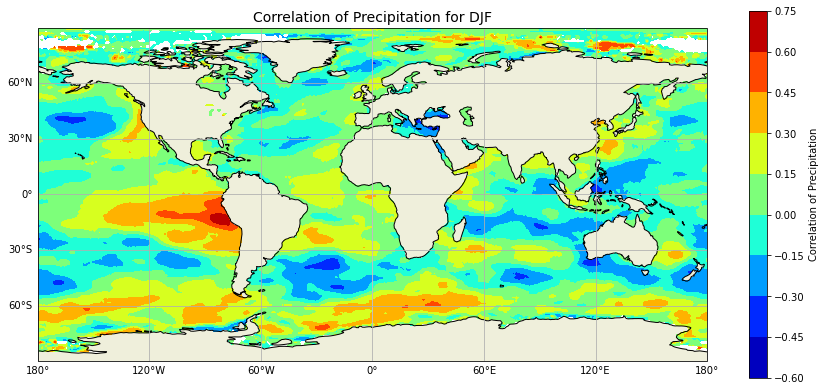

In [19]:

# converting the correlation data into a numpy array to make plotting easier. 

lon = winter_corr['lon'].to_numpy()
lat = winter_corr['lat'].to_numpy()
winter = winter_corr.to_numpy()

# creating the graph in the code below. 
fig,ax = plt.subplots(figsize=(15,15),subplot_kw=dict(projection=ccrs.PlateCarree())) 

p = plt.contourf(lon, lat, winter, cmap='jet')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Correlation of Precipitation for DJF', fontsize=14)
gl = ax.gridlines(draw_labels=True)
gl.right_labels= False
gl.top_labels=False
plt.colorbar(p, shrink=0.45, label='Correlation of Precipitation')

plt.show()


![image-2.png](NinoRegions.png)

### It's interesting to see that the Nino region has the highest correlation but let's examine the location with the highest value. 

In [34]:

# getting the lat and lon of the highest correlation value
max_corr_coords = winter_corr.isel(winter_corr.argmax(dim=["lon", "lat"]))


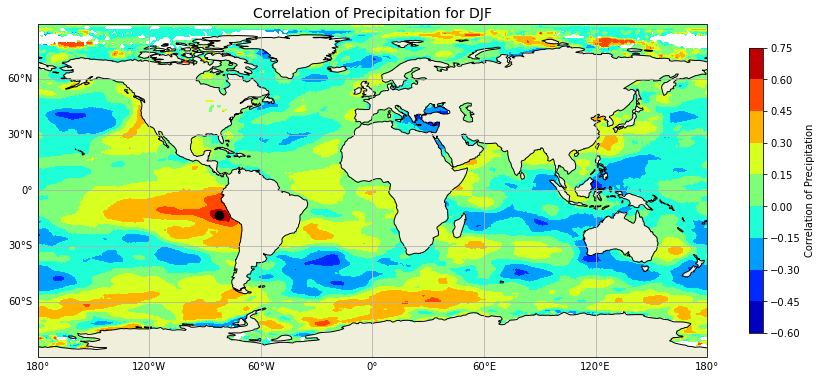

In [21]:

#creating a plot to show the location of the highest value
fig,ax = plt.subplots(figsize=(15,15),subplot_kw=dict(projection=ccrs.PlateCarree())) 

p = plt.contourf(lon, lat, winter, cmap='jet')
plt.scatter(x=max_corr_coords['lon']-360, y=max_corr_coords['lat'],
            color="k",
            s=75,
            transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Correlation of Precipitation for DJF', fontsize=14)
gl = ax.gridlines(draw_labels=True)
gl.right_labels= False
gl.top_labels=False
plt.colorbar(p, shrink=0.35, label='Correlation of Precipitation')

plt.show()


# Part 4: 

## Ordinary Least Squares Regression Model

### First, the data needs to be prepared for the 4 different models.

In [22]:

# slicing the sst dataset to only get data associated with the max correlation location
max_sst_coor = DJF_anomaly_sst.sel(lat=max_corr_coords['lat'], lon=max_corr_coords['lon'])

# need to have the same dates when running the models
sst = max_sst_coor.sel(time=slice('1982-02-28','2021-02-28'))
precip = DJF_time_precip.sel(time=slice('1982-02-28','2021-02-28')) 

# converting to numpy arrays for easier processing
numpy_sst = sst['sst'].to_numpy()
numpy_precip = precip['precip'].to_numpy()

#Let's take a new approach by just looking at times when the data is in a La Nina or El Nino. 
nino = DJF_sst_nino.where((DJF_sst_nino['sst'] >= 0.5) | (DJF_sst_nino['sst'] <= -0.5))
only_nino = nino.dropna(dim='time')

# finding the times that match both datasets by using the intersect1d method
same_times = np.intersect1d(only_nino.time,precip.time)
only_nino=only_nino.sel(time=same_times)
sel_precip = precip.sel(time=same_times)

# making numpy arrays of data that just times in either an El Nino or La Nina phase
numpy_only_nino = only_nino['sst'].to_numpy()
numpy_only_precip = sel_precip['precip'].to_numpy()

# separate the data into periods of either El Nino or La Nina 
el_nino = DJF_sst_nino.where(DJF_sst_nino['sst'] >= 0.5)
only_el_nino = el_nino.dropna(dim='time')

la_nina = DJF_sst_nino.where(DJF_sst_nino['sst'] <= 0.5)
only_la_nina = la_nina.dropna(dim='time')

# making the times the same for both datasets
same_times = np.intersect1d(only_el_nino.time,precip.time)
only_el_nino=only_el_nino.sel(time=same_times)
el_precip = precip.sel(time=same_times)

same_times = np.intersect1d(only_la_nina.time,precip.time)
only_la_nina=only_la_nina.sel(time=same_times)
la_precip = precip.sel(time=same_times)

#converting both datasets into numpy arrays
numpy_only_el_nino = only_el_nino['sst'].to_numpy()
numpy_only_el_precip = el_precip['precip'].to_numpy()

numpy_only_la_nina = only_la_nina['sst'].to_numpy()
numpy_only_la_precip = la_precip['precip'].to_numpy()

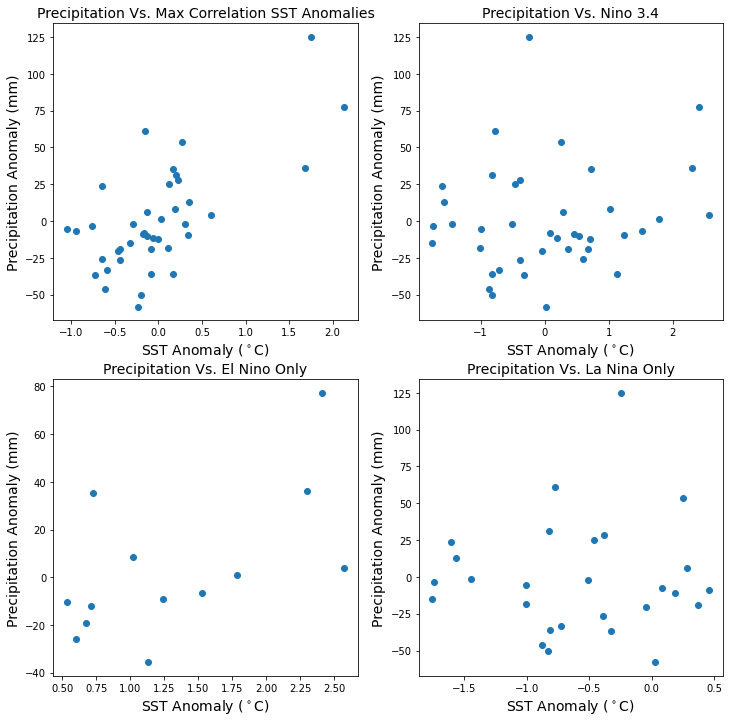

In [32]:

# creating 2x2 subplot for all precip vs sst anomalies
fig, ax = plt.subplots(2,2, figsize=(12, 12))

# max correlation location versus precipitation anomalies over Lake Tahoe
ax[0,0].scatter(sst['sst'], precip['precip'])
ax[0,0].set_ylabel('Precipitation Anomaly (mm)', fontsize=14)
ax[0,0].set_xlabel('SST Anomaly ($^\circ$C)', fontsize=14)
ax[0,0].set_title('Precipitation Vs. Max Correlation SST Anomalies', fontsize=14)

# nino 3.4 region versus precip anomalies
ax[0,1].scatter(numpy_sst_nino, numpy_precip)
ax[0,1].set_ylabel('Precipitation Anomaly (mm)', fontsize=14)
ax[0,1].set_xlabel('SST Anomaly ($^\circ$C)', fontsize=14)
ax[0,1].set_title('Precipitation Vs. Nino 3.4', fontsize=14)

# just times when El Nino is present versus precipitation anomalies
ax[1,0].scatter(numpy_only_el_nino, numpy_only_el_precip)
ax[1,0].set_ylabel('Precipitation Anomaly (mm)', fontsize=14)
ax[1,0].set_xlabel('SST Anomaly ($^\circ$C)', fontsize=14)
ax[1,0].set_title('Precipitation Vs. El Nino Only', fontsize=14)

# just times when la nina is present versus precipitation anomalies
ax[1,1].scatter(numpy_only_la_nina, numpy_only_la_precip)
ax[1,1].set_ylabel('Precipitation Anomaly (mm)', fontsize=14)
ax[1,1].set_xlabel('SST Anomaly ($^\circ$C)', fontsize=14)
ax[1,1].set_title('Precipitation Vs. La Nina Only', fontsize=14)

plt.show()

In [33]:


# ----first running the max correlation location against the precip over Lake Tahoe----


print('Max Correlation Location', '\n', '\n')

# need to convert to numpy for model
y_max = numpy_precip
x_max = numpy_sst

# running the OLS regression model
x2_max = sm.add_constant(x_max) 
mod_uni_max = sm.OLS(y_max,x2_max).fit()
y_pred_uni_max = mod_uni_max.fittedvalues
max_p_val = mod_uni_max.pvalues

# printing the summary out
print(mod_uni_max.summary())


# ----this is the data with all times when an El Nino ro La Nina was present----


print('\n', '\n',"All Nino's Only", '\n', '\n')

# need to convert to numpy for model
y_nino = numpy_precip
x_nino = numpy_sst_nino

# running the OLS regression model
x2_nino = sm.add_constant(x_nino) 
mod_uni_nino = sm.OLS(y_nino,x2_nino).fit()
y_pred_uni_nino = mod_uni_nino.fittedvalues
nino_p_val = mod_uni_nino.pvalues

# printing the summary out
print(mod_uni_nino.summary())



# ----using El Nino times only for model----


print('El Nino Only', '\n', '\n')

# need to convert to numpy for model
y_el_nino = numpy_only_precip
x_el_nino = numpy_only_nino

# running the OLS regression model
x2_el_nino = sm.add_constant(x_el_nino) 
mod_uni_el_nino = sm.OLS(y_el_nino,x2_el_nino).fit()
y_pred_uni_el_nino = mod_uni_el_nino.fittedvalues
el_nino_p_val = mod_uni_el_nino.pvalues

# printing the El Nino summary out
print(mod_uni_el_nino.summary())


# ----using La Nina only for model----


print('\n', '\n', 'La Nina Only', '\n', '\n')

# need to convert to numpy for model
y_la_nina = numpy_only_la_precip
x_la_nina = numpy_only_la_nina

# running the OLS regression model
x2_la_nina = sm.add_constant(x_la_nina) 
mod_uni_la_nina = sm.OLS(y_la_nina,x2_la_nina).fit()
y_pred_uni_la_nina = mod_uni_la_nina.fittedvalues
la_nina_p_val = mod_uni_la_nina.pvalues

# printing the La Nina summary out
print(mod_uni_la_nina.summary())


Max Correlation Location 
 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     31.25
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           2.08e-06
Time:                        19:14:10   Log-Likelihood:                -187.71
No. Observations:                  40   AIC:                             379.4
Df Residuals:                      38   BIC:                             382.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9214  

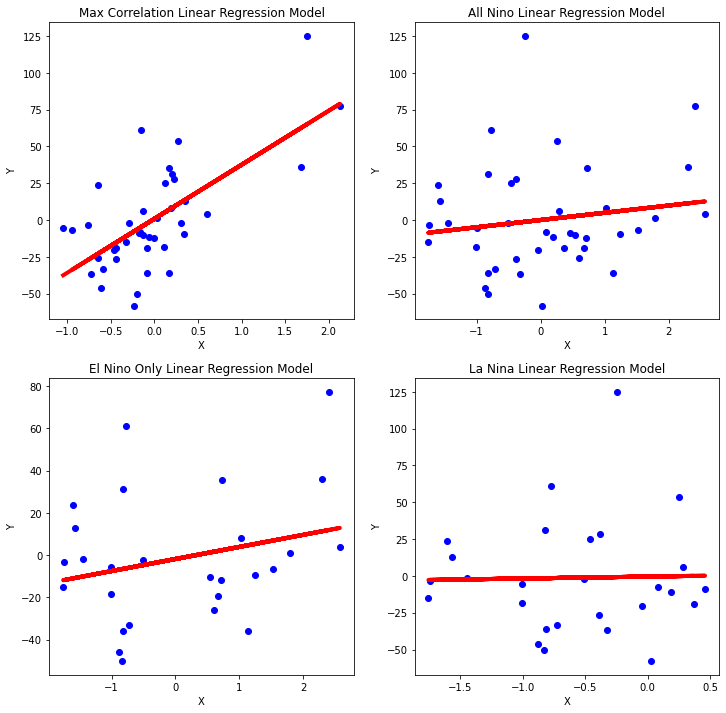

In [26]:

# creating subplots that have all 4 linear regression models on their own plots
fig, ax = plt.subplots(2,2, figsize=(12, 12))

# max correlation data
ax[0,0].scatter(x_max, y_max, color='b')
ax[0,0].set_xlabel('X')
ax[0,0].set_ylabel('Y')
ax[0,0].set_title('Max Correlation Linear Regression Model')
ax[0,0].plot(x_max, y_pred_uni_max, color='red',linewidth=4)

# all nino's data
ax[0,1].scatter(x_nino, y_nino, color='b')
ax[0,1].set_xlabel('X')
ax[0,1].set_ylabel('Y')
ax[0,1].set_title('All Nino Linear Regression Model')
ax[0,1].plot(x_nino, y_pred_uni_nino, color='red',linewidth=4)

# only el nino data
ax[1,0].scatter(x_el_nino, y_el_nino, color='b')
ax[1,0].set_xlabel('X')
ax[1,0].set_ylabel('Y')
ax[1,0].set_title('El Nino Only Linear Regression Model')
ax[1,0].plot(x_el_nino, y_pred_uni_el_nino, color='red',linewidth=4)

# only la nina data
ax[1,1].scatter(x_la_nina, y_la_nina, color='b')
ax[1,1].set_xlabel('X')
ax[1,1].set_ylabel('Y')
ax[1,1].set_title('La Nina Linear Regression Model')
ax[1,1].plot(x_la_nina, y_pred_uni_la_nina, color='red',linewidth=4)

plt.show()

In [27]:

# closer look at all 4 of the R^2 using in the models
print('Max Correlation R^2 = ',mod_uni_max.rsquared)
print('All Nino R^2 = ',mod_uni_nino.rsquared)
print('El Nino R^2 = ',mod_uni_el_nino.rsquared)
print('La Nina R^2 = ',mod_uni_la_nina.rsquared)

Max Correlation R^2 =  0.4512575319752695
All Nino R^2 =  0.02362783116796907
El Nino R^2 =  0.06530501258768107
La Nina R^2 =  0.0004986957540700221


In [31]:

# p-values for all models
print('p-values Max Correlation:', max_p_val)
print("p-values Nina's:", nino_p_val)
print('p-values El Nino:', el_nino_p_val)
print('p-values La Nina:', la_nina_p_val)

p-values Max Correlation: [8.30949455e-01 2.07786400e-06]
p-values Nina's: [0.98926295 0.34364584]
p-values El Nino: [0.7566818  0.19826052]
p-values La Nina: [0.96511456 0.91196613]


In [28]:

# calculating the RMSE
rmse_err_uni_max = mean_squared_error(y_max, y_pred_uni_max,squared=False)
rmse_err_uni_nino = mean_squared_error(y_nino, y_pred_uni_nino,squared=False)
rmse_err_uni_el_nino = mean_squared_error(y_el_nino, y_pred_uni_el_nino,squared=False)
rmse_err_uni_la_nina = mean_squared_error(y_la_nina, y_pred_uni_la_nina,squared=False)

# printing out the 4 different RMSE for comparison 
print('Max Correlation RMSE = ',rmse_err_uni_max)
print('All Nino RMSE = ',rmse_err_uni_nino)
print('El Nino RMSE = ',rmse_err_uni_el_nino)
print('La Nina RMSE = ',rmse_err_uni_la_nina)


Max Correlation RMSE =  26.412512407621257
All Nino RMSE =  35.23166142181859
El Nino RMSE =  29.037080510933066
La Nina RMSE =  38.23940244004611


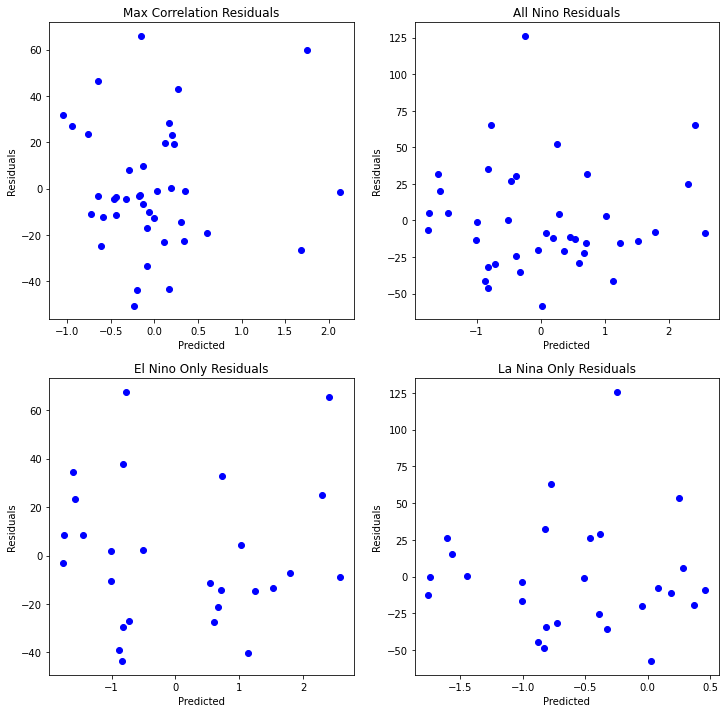

In [30]:

# these subplots show the residuals for the models
fig, ax = plt.subplots(2,2, figsize=(12, 12))

# max corelation data
ax[0,0].scatter(x_max,y_max-y_pred_uni_max,color='b')
ax[0,0].set_xlabel('Predicted')
ax[0,0].set_ylabel('Residuals')
ax[0,0].set_title('Max Correlation Residuals')

# all nino data
ax[0,1].scatter(x_nino,y_nino-y_pred_uni_nino,color='b')
ax[0,1].set_xlabel('Predicted')
ax[0,1].set_ylabel('Residuals')
ax[0,1].set_title('All Nino Residuals')

# only el nino data
ax[1,0].scatter(x_el_nino,y_el_nino-y_pred_uni_el_nino,color='b')
ax[1,0].set_xlabel('Predicted')
ax[1,0].set_ylabel('Residuals')
ax[1,0].set_title('El Nino Only Residuals')

# only la nina data
ax[1,1].scatter(x_la_nina,y_la_nina-y_pred_uni_la_nina,color='b')
ax[1,1].set_xlabel('Predicted')
ax[1,1].set_ylabel('Residuals')
ax[1,1].set_title('La Nina Only Residuals')

plt.show()


# Part 5: Conclusion 

### In this analysis, we meticulously purged both datasets of any potential errors. The precipitation data was meticulously refined to only encompass the Lake Tahoe region, while the sea surface data was carefully sliced to align with the time frame of the precipitation dataset. Subsequently, we resampled the datasets into quarters using the resample method and grouped them into seasons. The winter season was selected based on the period of time with the highest precipitation values, which effectively eliminated some of the seasonality from the data. To create the anomalies used in the model, we generated a 30-year time mean covering the period from 1982 to 2012.

### To analyze the four distinct datasets, we employed ordinary least squares regression models. These models looked at various factors, including the location with the maximum correlation, all time periods within the El Nino/La Nina range, solely the El Nino range, and exclusively the La Nina range. Of all the models, the one that stood out the most was the max correlation model, outperforming all the others in every metric, albeit not to an impressive degree. Unfortunately, none of the models boasted high R^2 values, and the p-values indicated that they were not statistically significant. Nevertheless, the Durbin-Watson value showed no evidence of serial correlation.

### For the study to be more robust, it is essential to have precipitation data spanning a longer timeframe. Furthermore, it would be fascinating to observe how the models change by shifting the precipitation viewing window from the east side of the Sierra Mountains to the west side, thereby allowing for a comparison of the models' performance.


# Thank you for your time
### Garrick Hague
